In [1]:
!pip install pandas matplotlib numpy statsforecast prophet scikit-learn scipy pyarrow seaborn xgboost h2o sktime tsfresh pmdarima plotly graphviz

  Using cached pandas-2.1.1-cp39-cp39-macosx_11_0_arm64.whl (10.9 MB)
  Using cached matplotlib-3.8.0-cp39-cp39-macosx_11_0_arm64.whl (7.5 MB)
  Using cached numpy-1.26.0-cp39-cp39-macosx_11_0_arm64.whl (14.0 MB)
  Using cached statsforecast-1.6.0-py3-none-any.whl (110 kB)
  Using cached prophet-1.1.4-py3-none-macosx_11_0_arm64.whl
  Using cached scikit_learn-1.3.1-cp39-cp39-macosx_12_0_arm64.whl (9.5 MB)
  Using cached scipy-1.11.2-cp39-cp39-macosx_12_0_arm64.whl (29.6 MB)
  Using cached pyarrow-13.0.0-cp39-cp39-macosx_11_0_arm64.whl (23.7 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached xgboost-2.0.0-py3-none-macosx_12_0_arm64.whl (1.9 MB)
  Using cached h2o-3.42.0.3.tar.gz (240.9 MB)
  Preparing metadata (setup.py) ... done
  Using cached sktime-0.23.0-py3-none-any.whl (17.5 MB)
  Using cached tsfresh-0.20.1-py2.py3-none-any.whl (95 kB)
  Using cached pmdarima-2.0.3-cp39-cp39-macosx_11_0_arm64.whl (580 kB)
  Using cached plotly-5.17.0-py2.py3-none-any.whl (

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

: 

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


: 

# XGBoost

In [ ]:
# start from csv
X_train = pd.read_csv('X_train.csv', index_col=0)
X_test = pd.read_csv('X_test.csv', index_col=0)

# convert index to datetime
X_train.index = pd.to_datetime(X_train.index).astype('datetime64[ns]')
X_test.index = pd.to_datetime(X_test.index).astype('datetime64[ns]')

: 

In [ ]:
#X_train.index = pd.to_datetime(X_train.index)
print(X_train.dtypes)

absolute_humidity_2m:gm3          float64
air_density_2m:kgm3               float64
ceiling_height_agl:m              float64
clear_sky_energy_1h:J             float64
clear_sky_rad:W                   float64
cloud_base_agl:m                  float64
dew_or_rime:idx                   float64
dew_point_2m:K                    float64
diffuse_rad:W                     float64
diffuse_rad_1h:J                  float64
direct_rad:W                      float64
direct_rad_1h:J                   float64
effective_cloud_cover:p           float64
elevation:m                       float64
fresh_snow_12h:cm                 float64
fresh_snow_1h:cm                  float64
fresh_snow_24h:cm                 float64
fresh_snow_3h:cm                  float64
fresh_snow_6h:cm                  float64
is_day:idx                        float64
is_in_shadow:idx                  float64
msl_pressure:hPa                  float64
precip_5min:mm                    float64
precip_type_5min:idx              

: 

In [ ]:
print(X_train.isna().sum())
#print((X_test == np.inf).sum())
#print((X_test == -np.inf).sum())

absolute_humidity_2m:gm3            8874
air_density_2m:kgm3                 8874
ceiling_height_agl:m               26044
clear_sky_energy_1h:J               8874
clear_sky_rad:W                     8874
cloud_base_agl:m                   16113
dew_or_rime:idx                     8874
dew_point_2m:K                      8874
diffuse_rad:W                       8874
diffuse_rad_1h:J                    8874
direct_rad:W                        8874
direct_rad_1h:J                     8874
effective_cloud_cover:p             8874
elevation:m                         8874
fresh_snow_12h:cm                   8874
fresh_snow_1h:cm                    8874
fresh_snow_24h:cm                   8874
fresh_snow_3h:cm                    8874
fresh_snow_6h:cm                    8874
is_day:idx                          8874
is_in_shadow:idx                    8874
msl_pressure:hPa                    8874
precip_5min:mm                      8874
precip_type_5min:idx                8874
pressure_100m:hP

: 

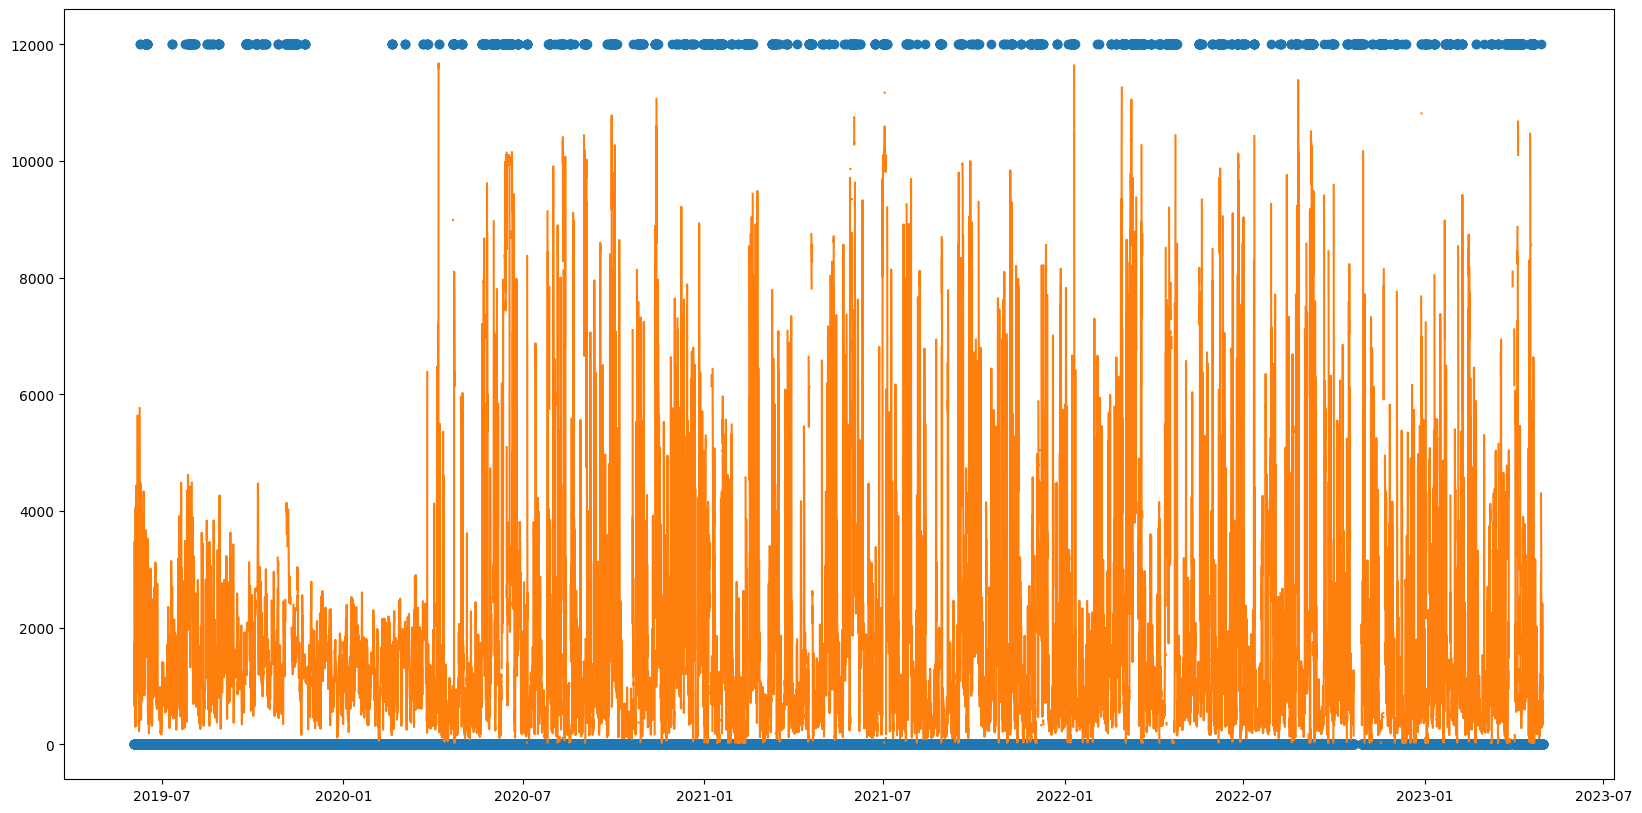

: 

In [ ]:
# lets check location A
temp = X_train.query('location_A == 1')
temp.isna().sum()

# plot the places in time with missing values
plt.figure(figsize=(20,10))
plt.plot(temp.index, temp["cloud_base_agl:m"].isna()*12000, 'o')
plt.plot(temp.index, temp["cloud_base_agl:m"])
plt.show()

In [ ]:
lag_range = list(range(24, 24*3, 24)) + list(range(1, 3)) #
#print(lag_range)
#lag_range = []
# for the xgboost, we should create lag_features
# historically lagged values
def construct_lag_features(df, lags, variable):
  for lag in lags:
    idx_shift = lag
    for location in df['location'].unique():
      df[f'{variable}_lag_{lag}_hours'] = df.groupby('location')[variable].shift(idx_shift)
  
      # # construct rolling features, such as rolling mean, rolling std
      # df[f'{variable}_rolling_mean_{lag}_hours'] = df.groupby('location')[variable].shift(idx_shift).rolling(window=lag).mean()
      # df[f'{variable}_rolling_std_{lag}_hours'] = df.groupby('location')[variable].shift(idx_shift).rolling(window=lag).std()

  return df


def add_lags(df):
  # Step 1: Reverse One-Hot Encoding
  location_columns = ['location_A', 'location_B', 'location_C']  # Add more as needed
  df['location'] = df[location_columns].idxmax(axis=1)

  # Step 2: Construct Lag Features
  df = construct_lag_features(df, lag_range, "y")

  # Step 3: Drop Temporary 'location' Column
  df.drop('location', axis=1, inplace=True) 

  return df

: 

# Normalize values

In [ ]:
# normalize the y-values between 0 and 1
def normalize_y(df):
    #save something so we can denormalize later
    mi = df['y'].min()
    ma = df['y'].max()
    #normalize
    df['y'] = 1000*(df['y'] - mi)/(ma - mi)
    return df, mi, ma

min_max_dict = {}

# # for each location, we need to normalize the y-values
# for location in ['A', 'B', 'C']:
#     y = X_train[X_train[f"location_{location}"] == 1]['y']
#     X_train.loc[X_train[f"location_{location}"] == 1, 'y'], mi, ma = normalize_y(X_train[X_train[f"location_{location}"] == 1])
    
#     min_max_dict[location] = (mi, ma)

    


: 

In [ ]:
X_train = add_lags(X_train)
X_train.tail()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,quarter_of_year,is_weekend,location_A,location_B,location_C,y,y_lag_24_hours,y_lag_48_hours,y_lag_1_hours,y_lag_2_hours
2023-04-30 19:00:00,4.4,1.27550,1456.574951,84010.148438,4.175,551.224976,0.0,272.024994,2.775,54774.000000,...,2,1,0,0,1,50.96,30.38,30.38,175.42,190.12
2023-04-30 20:00:00,4.4,1.27850,1476.349976,2206.800049,0.000,564.099976,0.0,271.950012,0.000,4984.049805,...,2,1,0,0,1,2.94,2.94,2.94,50.96,175.42
2023-04-30 21:00:00,4.4,1.27900,1516.300049,0.000000,0.000,578.700012,0.0,271.899994,0.000,0.000000,...,2,1,0,0,1,0.00,0.00,0.00,2.94,50.96
2023-04-30 22:00:00,4.4,1.27975,1240.599976,0.000000,0.000,551.500000,0.0,271.950012,0.000,0.000000,...,2,1,0,0,1,-0.00,-0.00,-0.00,0.00,2.94
2023-04-30 23:00:00,4.4,1.27975,1484.500000,0.000000,0.000,558.674988,0.0,271.950012,0.000,0.000000,...,2,1,0,0,1,-0.00,-0.00,-0.00,-0.00,0.00


: 

In [ ]:
print("Nan values in X_test?")
print(X_test.isna().sum())
print("Any infinities?")
print((X_test == np.inf).sum().sum())
print((X_test == -np.inf).sum().sum())  

Nan values in X_test?
absolute_humidity_2m:gm3          2448
air_density_2m:kgm3               2448
ceiling_height_agl:m              3018
clear_sky_energy_1h:J             2448
clear_sky_rad:W                   2448
cloud_base_agl:m                  2671
dew_or_rime:idx                   2448
dew_point_2m:K                    2448
diffuse_rad:W                     2448
diffuse_rad_1h:J                  2448
direct_rad:W                      2448
direct_rad_1h:J                   2448
effective_cloud_cover:p           2448
elevation:m                       2448
fresh_snow_12h:cm                 2448
fresh_snow_1h:cm                  2448
fresh_snow_24h:cm                 2448
fresh_snow_3h:cm                  2448
fresh_snow_6h:cm                  2448
is_day:idx                        2448
is_in_shadow:idx                  2448
msl_pressure:hPa                  2448
precip_5min:mm                    2448
precip_type_5min:idx              2448
pressure_100m:hPa                 2448
pre

: 

In [ ]:
# X_train.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx', 'wind_speed_v_10m:ms', ], inplace=True, errors='ignore')
# X_test.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx'], inplace=True, errors='ignore')

#X_train.shape, y_train.shape, type(X_train), type(y_train), len(X_train.columns)

: 

In [ ]:
# for each location, only use first 50% of data
#X_train, y_train = X_train.iloc[:int(X_train.shape[0])], y_train.iloc[:int(y_train.shape[0])]

: 

In [ ]:
# print all columns
print("All columns")
print(X_train.columns)

All columns
Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'win

: 

In [ ]:
# remove features with correlation below threshold (except for location and time stuff
# to_remove = ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K', 'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d', 'super_cooled_liquid_water:kgm2', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']

to_keep = ['clear_sky_energy_1h:J', 'clear_sky_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'sun_elevation:d', 'hour_of_day', 'month_of_year',
       'quarter_of_year', 'location_A', 'location_B',
       'location_C', 'y']

to_remove = [col for col in X_train.columns if col not in to_keep and "rolling" not in col and "lag" not in col]

X_train.drop(columns=to_remove, inplace=True, errors='ignore')
X_test.drop(columns=to_remove, inplace=True, errors='ignore')




: 

Features with correlation below threshold
['effective_cloud_cover:p', 'hour_of_day', 'month_of_year', 'quarter_of_year', 'location_B', 'location_C']


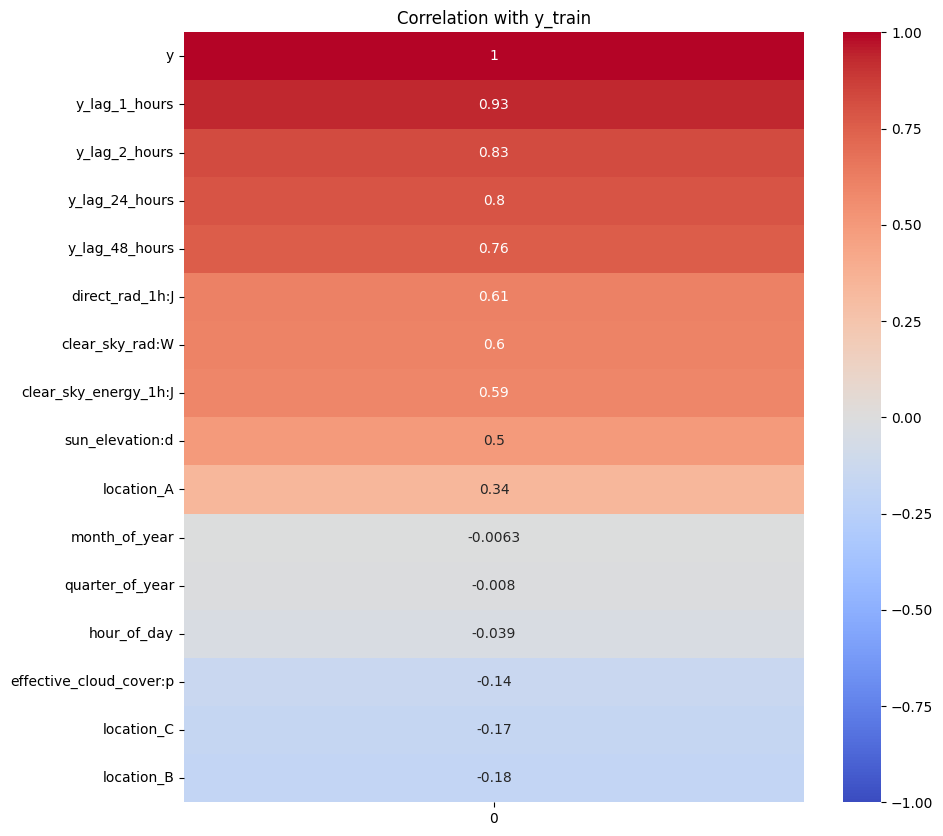

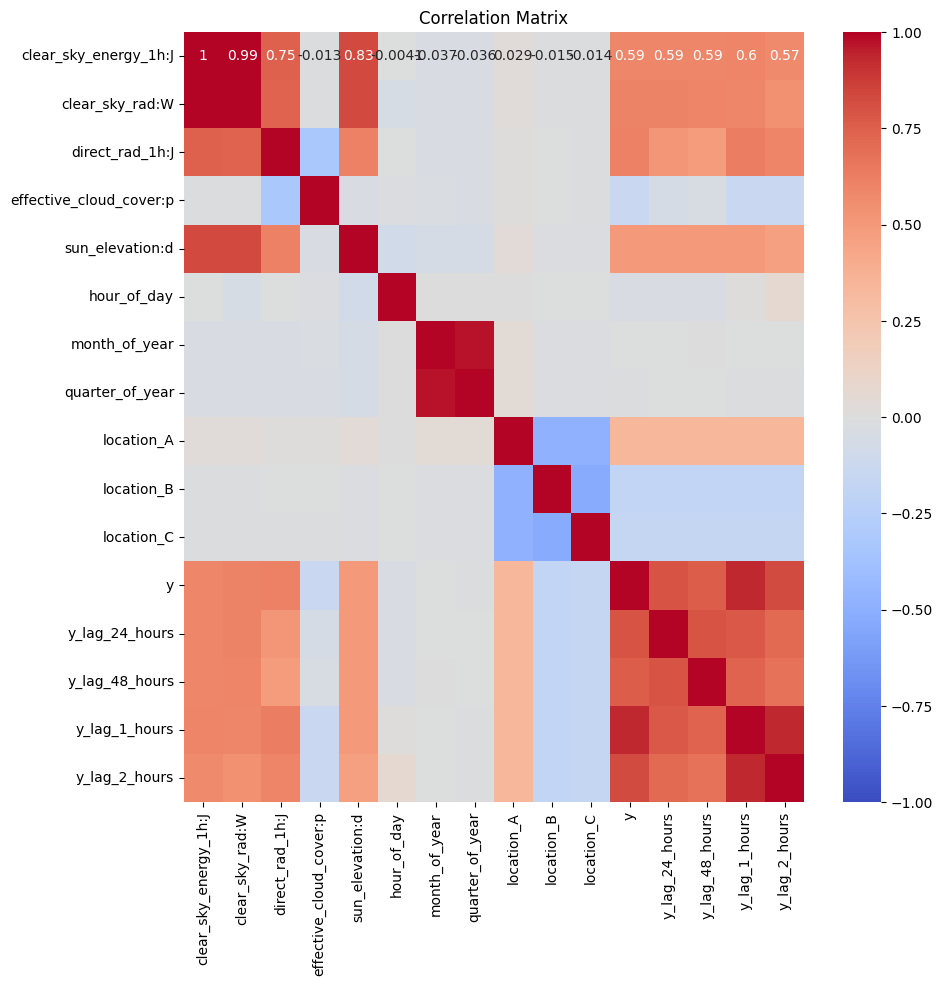

: 

In [ ]:
def features_with_correlation_below_threshold(X_train, threshold=0.3):
    # Calculate correlation for all features, with the Y value.
    # If correlation is below threshold, add to list of features to drop
    y_train = X_train['y']
    features_to_drop = []
    for feature in X_train.columns:
        correlation = X_train[feature].corr(y_train)
        if abs(correlation) < threshold:
            features_to_drop.append(feature)
    return features_to_drop



print("Features with correlation below threshold")
print(features_with_correlation_below_threshold(X_train, 0.3))

# print correlation matrix with y_train as nice plot
corr = X_train.corrwith(X_train['y'])
corr = corr.sort_values(ascending=False)
plt.figure(figsize=(10, 10))
sns.heatmap(corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with y_train')
plt.show()

# plot correlation matrix with itself
corr = X_train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

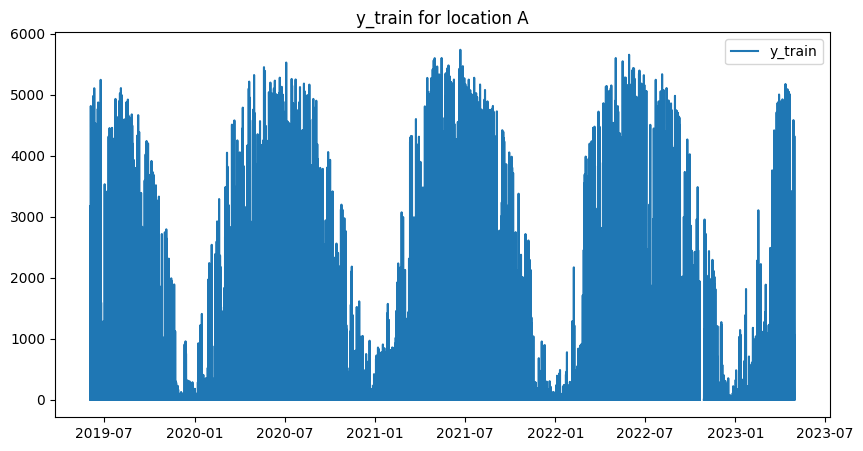

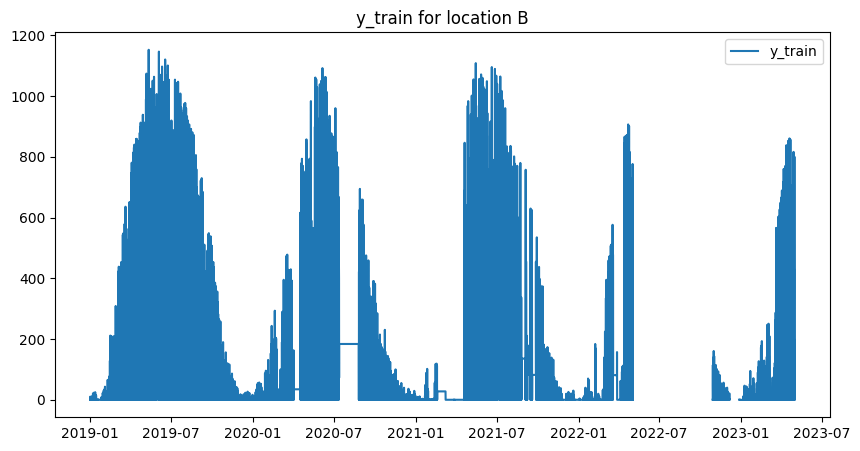

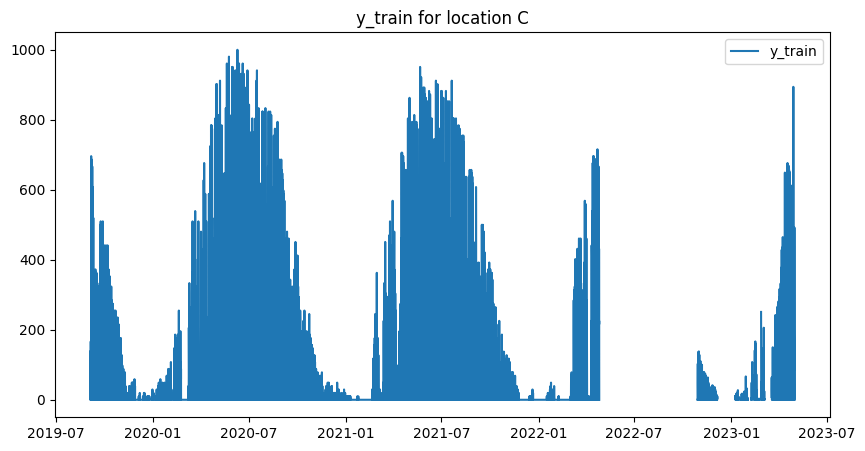

: 

In [ ]:
# plot all y_train values before model, one for each location
for location in ["A", "B", "C"]:
    plt.figure(figsize=(10, 5))
    plt.plot(X_train[X_train['location_'+location] == 1]['y'], label='y_train')
    plt.title(f'y_train for location {location}')
    plt.legend()
    plt.show()

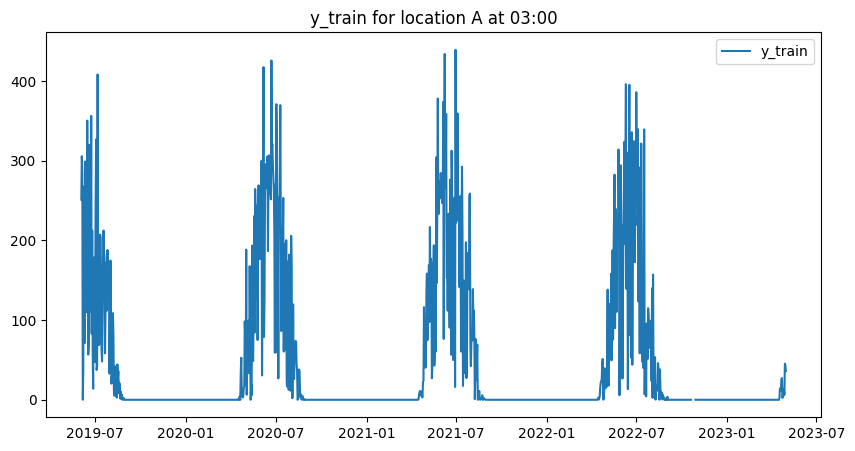

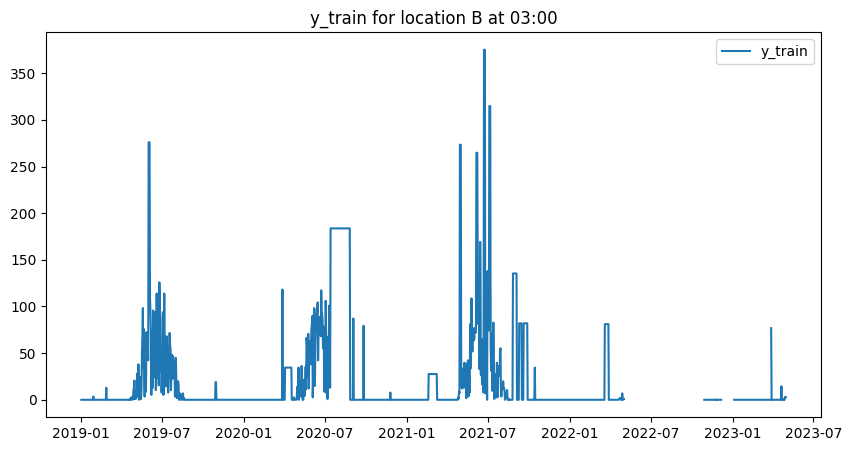

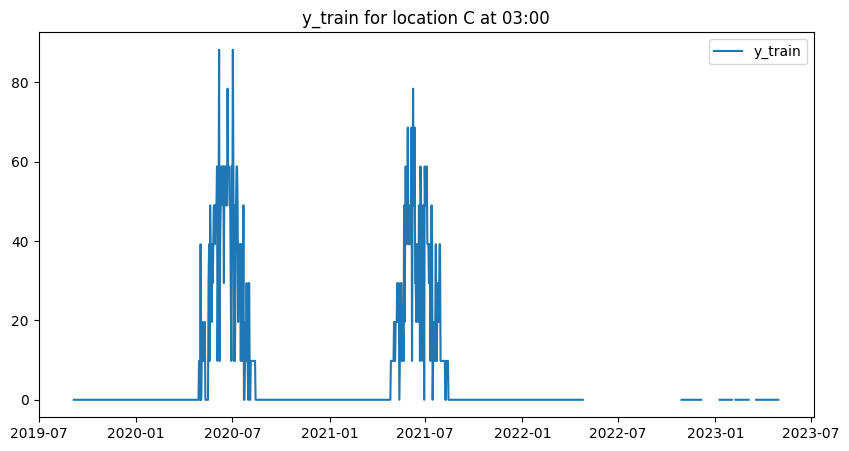

: 

In [ ]:
# plot all values for y for each location, for each day at 03:00 at night
for location in ["A", "B", "C"]:
    plt.figure(figsize=(10, 5))
    plt.plot(X_train[(X_train['location_'+location] == 1) & (X_train['hour_of_day'] == 3)]['y'], label='y_train')
    plt.title(f'y_train for location {location} at 03:00')
    plt.legend()
    plt.show()

In [ ]:
# from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
# t = TSFreshFeatureExtractor(default_fc_parameters="efficient", show_warnings=False)
# Xt = t.fit_transform(X_train)
# Xte = t.transform(X_test)


: 

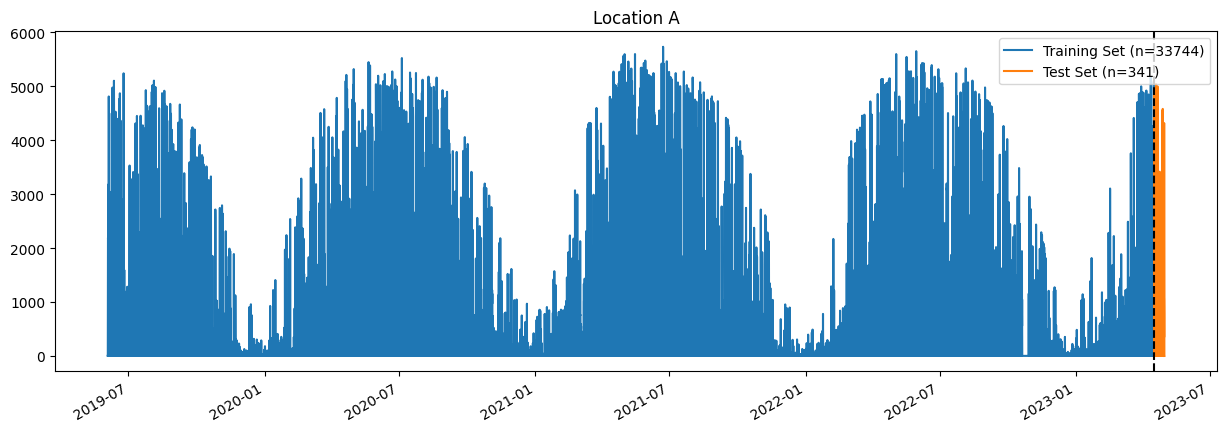

(33744, 15) (33744,)
[0]	validation_0-rmse:1151.61008	validation_0-mean_absolute_error:818.57910	validation_1-rmse:1476.96016	validation_1-mean_absolute_error:985.54626
[1]	validation_0-rmse:1141.18317	validation_0-mean_absolute_error:810.82501	validation_1-rmse:1463.72767	validation_1-mean_absolute_error:976.46588
[2]	validation_0-rmse:1130.86936	validation_0-mean_absolute_error:803.14807	validation_1-rmse:1450.63373	validation_1-mean_absolute_error:967.48242
[3]	validation_0-rmse:1120.66781	validation_0-mean_absolute_error:795.55743	validation_1-rmse:1437.70242	validation_1-mean_absolute_error:958.58557
[4]	validation_0-rmse:1110.57705	validation_0-mean_absolute_error:788.04626	validation_1-rmse:1424.84985	validation_1-mean_absolute_error:949.71643
[5]	validation_0-rmse:1100.59675	validation_0-mean_absolute_error:780.62280	validation_1-rmse:1412.19442	validation_1-mean_absolute_error:941.01935
[6]	validation_0-rmse:1090.72428	validation_0-mean_absolute_error:773.27405	validation_1-rm

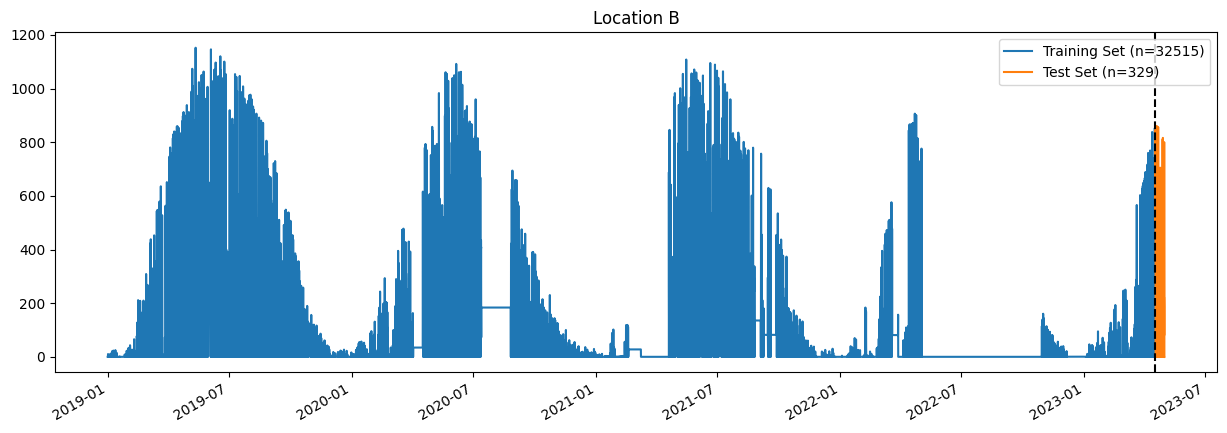

(32515, 15) (32515,)
[0]	validation_0-rmse:191.34791	validation_0-mean_absolute_error:127.65012	validation_1-rmse:259.26307	validation_1-mean_absolute_error:173.82454
[1]	validation_0-rmse:189.57565	validation_0-mean_absolute_error:126.41993	validation_1-rmse:256.92486	validation_1-mean_absolute_error:172.17569
[2]	validation_0-rmse:187.82206	validation_0-mean_absolute_error:125.20117	validation_1-rmse:254.60550	validation_1-mean_absolute_error:170.54515
[3]	validation_0-rmse:186.08738	validation_0-mean_absolute_error:123.99629	validation_1-rmse:252.30430	validation_1-mean_absolute_error:168.92064
[4]	validation_0-rmse:184.37099	validation_0-mean_absolute_error:122.80373	validation_1-rmse:250.04178	validation_1-mean_absolute_error:167.32233
[5]	validation_0-rmse:182.67284	validation_0-mean_absolute_error:121.62253	validation_1-rmse:247.77240	validation_1-mean_absolute_error:165.72801
[6]	validation_0-rmse:180.99285	validation_0-mean_absolute_error:120.45501	validation_1-rmse:245.53200	

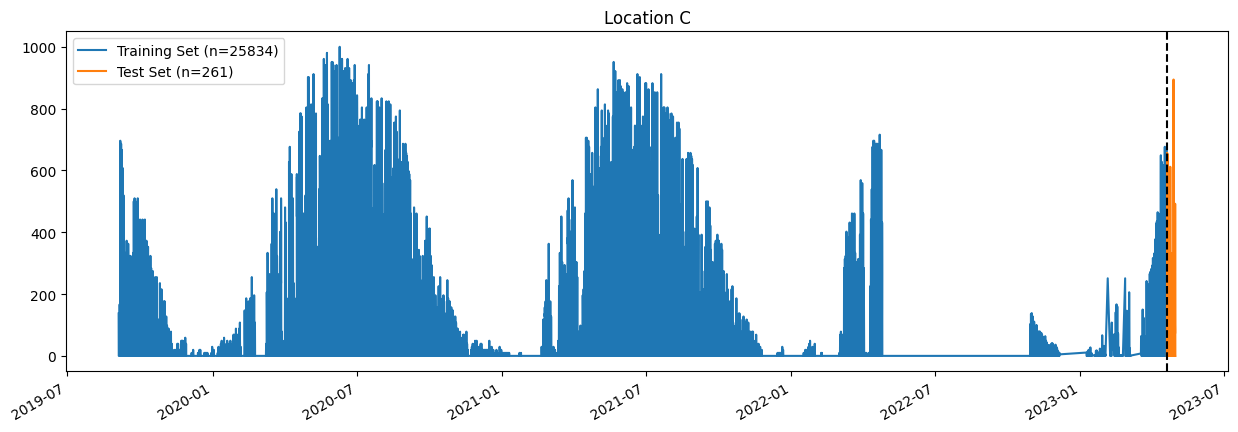

(25834, 15) (25834,)
[0]	validation_0-rmse:163.92407	validation_0-mean_absolute_error:108.14771	validation_1-rmse:196.17238	validation_1-mean_absolute_error:124.90208
[1]	validation_0-rmse:162.40520	validation_0-mean_absolute_error:107.09452	validation_1-rmse:194.50764	validation_1-mean_absolute_error:123.77959
[2]	validation_0-rmse:160.90241	validation_0-mean_absolute_error:106.05331	validation_1-rmse:192.86053	validation_1-mean_absolute_error:122.67026
[3]	validation_0-rmse:159.41554	validation_0-mean_absolute_error:105.02396	validation_1-rmse:191.23052	validation_1-mean_absolute_error:121.57226
[4]	validation_0-rmse:157.94446	validation_0-mean_absolute_error:104.00454	validation_1-rmse:189.60849	validation_1-mean_absolute_error:120.46971
[5]	validation_0-rmse:156.48980	validation_0-mean_absolute_error:102.99596	validation_1-rmse:188.00997	validation_1-mean_absolute_error:119.38980
[6]	validation_0-rmse:155.05015	validation_0-mean_absolute_error:101.99699	validation_1-rmse:186.42740	

: 

In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance, plot_tree

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import train_test_split

from statistics import mean


#reg = xgb.XGBRegressor(n_estimators=600, early_stopping_rounds=50, eval_metric=mean_absolute_error, learning_rate=0.01, booster="gbtree")
all_datasets = []
#reg = xgb.XGBRegressor(n_estimators=1300, eval_metric=mean_absolute_error, learning_rate=0.05, booster="dart")

models = []
# split into each location and train a model for each, A, B, C
for location in ["A", "B", "C"]:
    X_train_loc = X_train[X_train[f'location_{location}'] == 1]#.dropna()

    # get where y is not nan
    X_train_loc = X_train_loc[~X_train_loc['y'].isna()]


    # create train validate split
    X_train_loc, X_val_loc = train_test_split(X_train_loc, test_size=0.01, shuffle=False)


    # MAE
    reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, eval_metric=mean_absolute_error, learning_rate=0.01, booster="gbtree")
    #reg = xgb.XGBRegressor(n_estimators=1000, eval_metric=mean_absolute_error, learning_rate=0.01, booster="dart")



    y_train_loc = pd.Series(X_train_loc.pop('y').values, index=X_train_loc.index)
    y_val_loc = pd.Series(X_val_loc.pop('y').values, index=X_val_loc.index)

    fig, ax = plt.subplots(figsize=(15, 5))
    y_train_loc.plot(ax=ax, label='Training Set')
    y_val_loc.plot (ax=ax, label='Test Set')
    ax. axvline(x=y_train_loc.index[-1], color='black', linestyle='--')
    ax.set_title(f'Location {location}')
    ax.legend([f'Training Set (n={len(y_train_loc)})', f'Test Set (n={len(y_val_loc)})'])
    plt. show()


    print(X_train_loc.shape, y_train_loc.shape)



    reg.fit(X_train_loc, y_train_loc, eval_set=[(X_train_loc, y_train_loc), (X_val_loc, y_val_loc)], verbose=True)
    all_datasets.append((X_train_loc, y_train_loc, X_val_loc, y_val_loc))

    models.append(reg)


# # concat all datasets
# Xt_reg = pd.concat([x[0] for x in all_datasets])
# yt_reg = pd.concat([x[1] for x in all_datasets])
# Xv_reg = pd.concat([x[2] for x in all_datasets])
# yv_reg = pd.concat([x[3] for x in all_datasets])

# # fit model
# reg.fit(Xt_reg, yt_reg, eval_set=[(Xt_reg, yt_reg), (Xv_reg, yv_reg)], verbose=True)

# models = [reg] *3

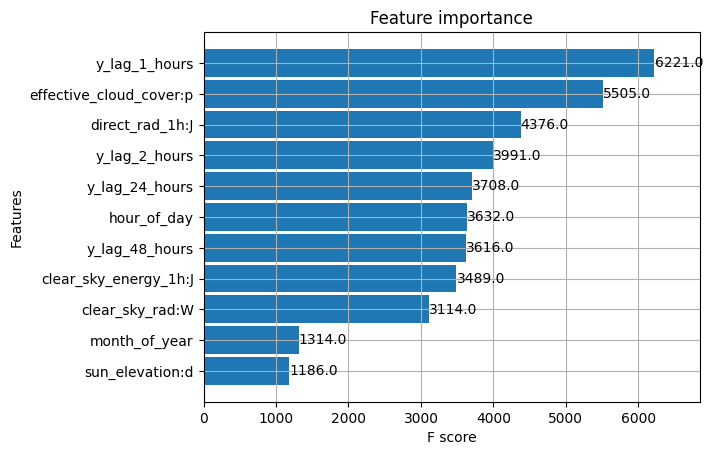

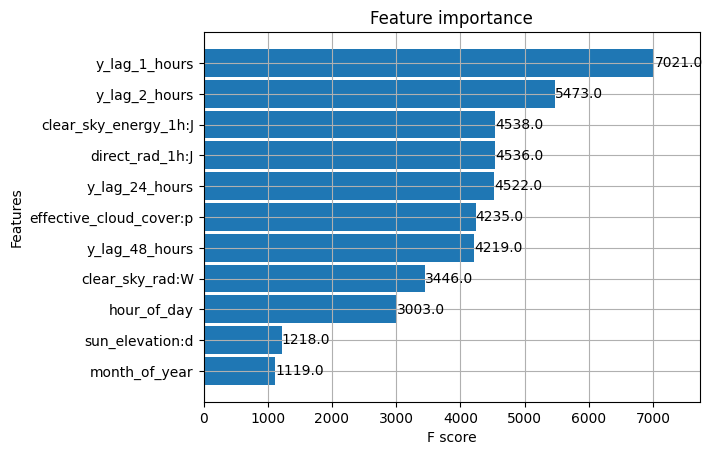

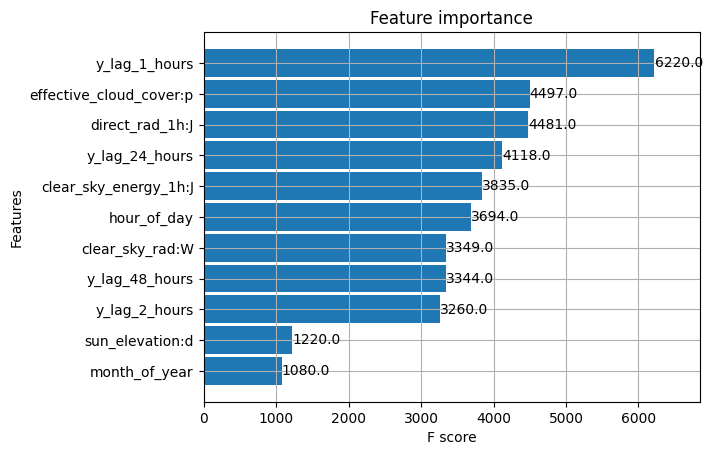

: 

In [ ]:
_ = plot_importance(models[0], height=0.9)
_ = plot_importance(models[1], height=0.9)
_ = plot_importance(models[2], height=0.9)


In [ ]:
#plot_tree(models[0], num_trees=0, rankdir='LR')

: 

In [ ]:
#def compute_lag_features_for_single_location()

def recursive_prediction(model, X_train, X_test):
    future_df = X_test.copy()
    future_df['isFuture'] = True
    past_df = X_train.copy()
    past_df['isFuture'] = False

    print("HEY", future_df.shape, past_df.shape)

    past_and_future_df = pd.concat([past_df, future_df])
    #print(past_and_future_df)

    past_and_future_df = add_lags(past_and_future_df)

    future_with_lags = past_and_future_df.query('isFuture').copy()

    
    #future_with_lags["y"] = model.predict(future_with_lags.drop(columns=['isFuture', 'y'], errors='ignore'))
    for ds in future_with_lags.index: # ds is the datestamp
        # one row at a time, use all rows up to that point to predict the next one
        #slc = past_and_future_df.loc[:ds].copy() # optimize by starting from x_train size - biggest lag
        m = max(lag_range) if lag_range else 1
        start_index = X_train.shape[0] - m
        start = X_train.index[start_index]
        slc = past_and_future_df.loc[start:ds].copy()

        
        #calculate lag features for this row
        slc = add_lags(slc) # this is why we need to use some part of the past, to calculate lag features
        
        # get only the last row, our current ds
        slc = slc.tail(1)

        # check that slc index is the same as ds
        assert slc.index[0] == ds

        # predict
        prediction = model.predict(slc.drop(columns=['isFuture', 'y'], errors='ignore'))[0]
        #print("TEST", type(prediction), prediction.shape, prediction)
        past_and_future_df.loc[ds, 'y'] = prediction

    
    #future_with_lags["y"].plot(figsize=(10, 5), color="red", ms=1, lw=1, title="Recursive Prediction")
    # print()

    future_with_lags = past_and_future_df.query('isFuture').copy()

    return pd.Series(future_with_lags["y"].values, index=X_test.index)
    




    




: 

In [ ]:
# for each location, predict the both X_test and X_train
# then calculate the error for each location (MAE)

# group by location, then predict to get prediction, then transform to series

predictions_test = []
predictions_train = []
for i, location in enumerate(['A', 'B', 'C']):
    print(f"Predicting for location {location}...")
    print(X_train.shape, X_test.shape)

    X_test_location = X_test[X_test[f'location_{location}'] == 1]
    X_train_location = X_train[X_train[f'location_{location}'] == 1]

    print(X_train_location.shape, X_test_location.shape)

    y_test_pred = recursive_prediction(models[i], X_train_location, X_test_location)
    #y_test_pred = pd.Series(models[i].predict(X_test_location), index=X_test_location.index)
    #y_test_pred.plot(figsize=(10, 5), color="red", ms=1, lw=1, title="Recursive Prediction")

    print(X_test_location.shape, y_test_pred.shape)

    predictions_test.append(y_test_pred)


    # drop y column
    X_train_location = X_train_location.drop(columns=['y'])
    print(X_train_location.shape)
    y_train_pred = models[i].predict(X_train_location)
    y_train_pred_series = pd.Series(y_train_pred, index=X_train_location.index)
    predictions_train.append(y_train_pred_series)



Predicting for location A...
(110164, 16) (4608, 11)
(34274, 16) (1536, 11)
HEY (1536, 12) (34274, 17)
(1536, 11) (1536,)
(34274, 15)
Predicting for location B...
(110164, 16) (4608, 11)
(37945, 16) (1536, 11)
HEY (1536, 12) (37945, 17)
(1536, 11) (1536,)
(37945, 15)
Predicting for location C...
(110164, 16) (4608, 11)
(37945, 16) (1536, 11)
HEY (1536, 12) (37945, 17)
(1536, 11) (1536,)
(37945, 15)


: 

In [ ]:
max(predictions_test[0])

5094.42236328125

: 

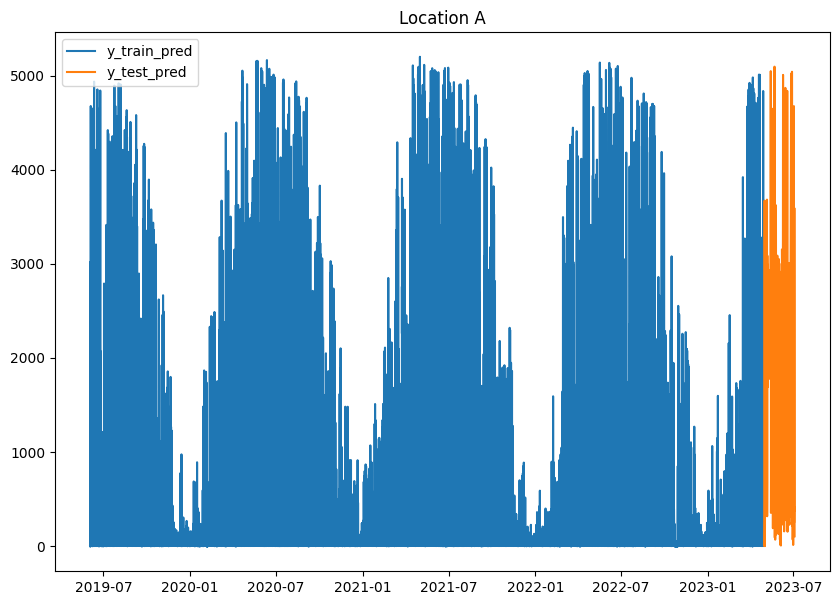

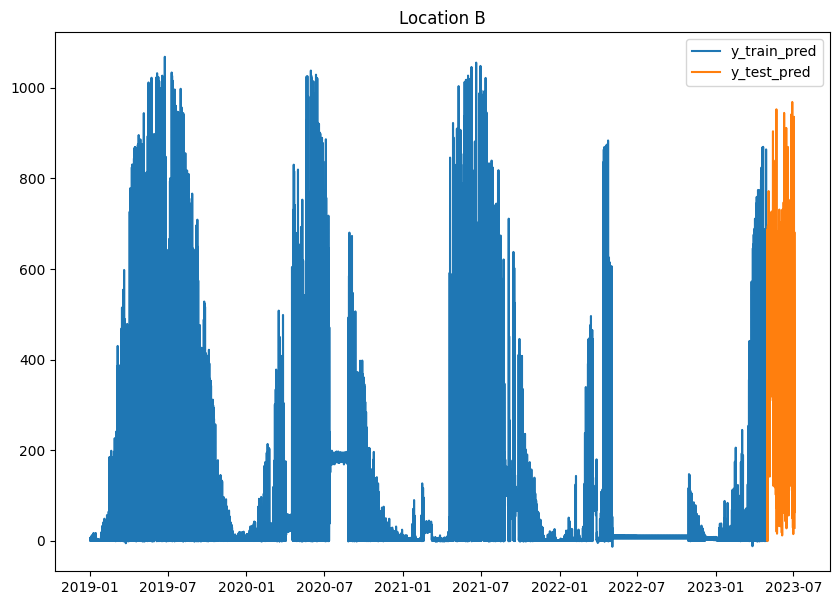

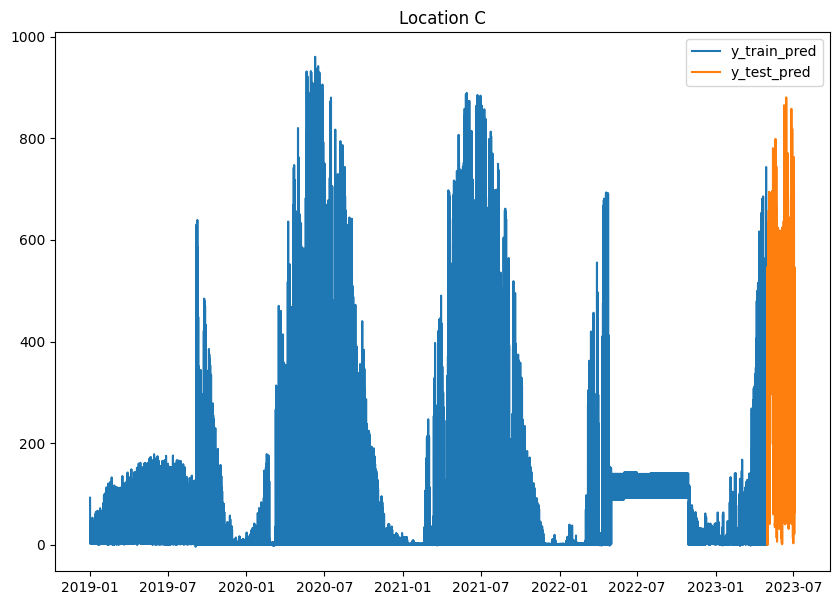

: 

In [ ]:
# plot predictions for each location
for i, location in enumerate(['A', 'B', 'C']):
    plt.figure(figsize=(10, 7))
    X_train_location = X_train[X_train[f'location_{location}'] == 1]
    y_train_location = pd.Series(X_train_location.pop('y').values, index=X_train_location.index)
    #plt.plot(y_train_location, label='y_train')
    plt.plot(predictions_train[i], label='y_train_pred')
    plt.plot(predictions_test[i], label='y_test_pred')
    plt.title(f"Location {location}")
    plt.legend()
    plt.show()

In [ ]:
# pull in test.csv and create submission.csv
test = pd.read_csv('test.csv', index_col=0)
# test has Id, Time, Location
# X_test has location_A, location_B, location_C
# we have to make sure that test has same dates as X_test, then predict y for each row in test, then save as submission.csv (using correct Id from test)

# convert index to datetime
test["id"] = test.index
test.set_index('time', inplace=True)
test.index = pd.to_datetime(test.index).astype('datetime64[ns]')
test

# split test into each location
print(test.groupby('location').count())




          prediction   id
location                 
A                720  720
B                720  720
C                720  720


: 

In [ ]:
#
# test_a = test[test['location'] == 'A']
# # check if any misisng days in test
# time_range = pd.date_range(start=test_a['time'].min(), end=test_a['time'].max(), freq='H')
# print(time_range.difference(test['time']))

: 

In [ ]:
import os
import pandas as pd

# Assuming X_test and model are already defined
# Assuming 'time' is also a datetime64[ns] column in X_test

models_dict = {
    'A': models[0],
    'B': models[1],
    'C': models[2]
}

# Initialize an empty DataFrame to store the results
submission_df = pd.DataFrame()

# Group test by 'location' and iterate through each group
for location, group in test.groupby('location'):
    # Filter X_test by the same location (if your X_test has location information)
    # If X_test has all locations merged, skip this step.
    X_test_location = X_test[X_test[f'location_{location}'] == 1]
    X_train_location = X_train[X_train[f'location_{location}'] == 1]
    
    
    # Run the model's prediction
    y_pred = recursive_prediction(models_dict[location], X_train_location, X_test_location)
    
    # change y_pred to df with datetime index and column 'y'
    y_pred = pd.DataFrame(y_pred, index=X_test_location.index, columns=['y'])

    # Merge group and y_pred based on the index
    merged_df = pd.merge_asof(group.sort_index(), y_pred.sort_index(),
                              left_index=True, right_index=True)
    
    #scale factor to denormalize
    if location in min_max_dict:
        print("Denormalizing...")
        mi, ma = min_max_dict[location]
        merged_df['y'] = merged_df['y'] * (ma - mi) / 1000 + mi

    # Create a DataFrame with 'Id' and predicted values
    result_df = pd.DataFrame({
        'id': merged_df['id'],
        'prediction': merged_df['y']
    })
    
    # Append to submission DataFrame
    submission_df = pd.concat([submission_df, result_df])


# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv
# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}.csv'

# Save the submission
submission_df.to_csv(os.path.join('submissions', new_filename), index=False)


HEY (1536, 12) (34274, 17)
HEY (1536, 12) (37945, 17)
HEY (1536, 12) (37945, 17)
Last submission number: 11


: 

: 